# <u>Kaggle Competition: Data Science Bowl 2017</u>

<img src="assets/logo.png" align="left" alt="Data Science Bowl 2017" style="width: 900px;"/>

### Description

_"In the United States, lung cancer strikes 225,000 people every year, and accounts for $12 billion in health care costs. Early detection is critical to give patients the best chance at recovery and survival._

_One year ago, the office of the U.S. Vice President spearheaded a bold new initiative, the Cancer Moonshot, to make a decade's worth of progress in cancer prevention, diagnosis, and treatment in just 5 years._

_In 2017, the Data Science Bowl will be a critical milestone in support of the Cancer Moonshot by convening the data science and medical communities to develop lung cancer detection algorithms._

_Using a data set of thousands of high-resolution lung scans provided by the National Cancer Institute, participants will develop algorithms that accurately determine when lesions in the lungs are cancerous. This will dramatically reduce the false positive rate that plagues the current detection technology, get patients earlier access to life-saving interventions, and give radiologists more time to spend with their patients._

_This year, the Data Science Bowl will award $1 million in prizes to those who observe the right patterns, ask the right questions, and in turn, create unprecedented impact around cancer screening care and prevention. The funds for the prize purse will be provided by the Laura and John Arnold Foundation."_

### Our Team
<p align="center">
<img src="" align="left" style="width: 85px;"/><img src="assets/chloe.jpeg" align="left" style="width: 85px;"/><img src="assets/ricky.jpeg" align="left" style="width: 85px;"/><img src="assets/martin.png" align="left" style="width: 85px;"/><img src="assets/matt.jpeg" align="left" style="width: 85px;"/>
</p>

[Chloe Pont](https://www.linkedin.com/in/chloepont/) | 
[Ricky Lui](https://www.linkedin.com/in/mingluiricky/) | 
[Martin Simanjuntak](https://www.linkedin.com/in/martinsimanjuntak/) | 
[Matthew Ho](https://www.linkedin.com/in/matthewwilfred/)

We are a team of Data Scientists based out of General Assembly London, here to give lung cancer a good kicking!

### Problem Statement

Given a dataset of low-dose CT scan images of patients' lungs, our goal is to accurately predict the probability of a patient actually developing lung cancer in one year's time from having the scan taken.

Essentialy, this is a __Supervised Machine Learning problem__ of __Binary Classification__. It is also an __image recognition problem__, one which Deep Learning and more specifically Convolutional Neural Networks have shown exceptional performance at solving in recent years.

Here are some key facts and figures of our dataset:

- 3D Lung scans of 1397 patients
- Each 3D image in DICOM format consists of layers of 512x512 pixel 2D scans stacked together
- Non-uniform number of stacks for patients, ranging anywhere from 70 to more than 200
- File sizes total up to 140GB
- 26% of the entire Training/Validation set is labelled cancerous, with the remaining labelled non-cancerous

The heterogeneity of our images necessitate an image preprocessing step, where we will apply such techniques as scaling, segmentation, thresholding etc. for feature engineering. Furthermore, the relatively large image sizes also call for rescaling and other methods to decrease the memory requirement for training our Machine Learning models. In particular, memory is expected to be a bottleneck for training Deep Neural Networks.

A forseeable problem is the small sample size with only 1397 patients. For Deep Learning purposes, convergence to a reasonable solution with low generalisation error generally requires much a much higher volume of training data. Data augmentation and transfer learning are some of the possible techniques we shall investigate over the course of this project.

### Our Approach

The roadmap to solving this problem will involve the following steps and associated technology stack:

- Data handling with Python, `numpy` and `pandas`
- Image preprocessing to deal with heterogeneous data using `SimpleITK`
- Deep Learning with `Keras`, specifically using Convolutional Neural Networks for image recognition
- Explore data augmentation and/or transfer learning to facilitate convergence with low generalisation error
- Amazon EC2 instances and S3 bins for training our Neural Networks
- Machine Learning models, in particular ensemble methods, will be trialled and evaluated on Validation set performance

### Success Metrics

For any Machine Learning project there must be metrics with which to judge our model's performance. Since our task is that of __binary classification__, we will be using __logarithmic loss__ (or log loss) as our success metric:

$$log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$

This general form of the equation applies to multiclass problems, which when limited to the case of binary classes becomes:

$$log loss = -\frac{1}{N}\sum_{i=1}^N {(y_i\log(p_i) + (1 - y_i)\log(1 - p_i))}$$

- $N$ is the number of patients in the set
- $ŷ_{i}$ is the predicted probability of the image belonging to a patient that will develop lung cancer
- $y_{i}$ is 1 if the diagnosis is cancer, 0 otherwise

Intuitively, log loss measures how wrong a model's predictions are: the higher the log loss, the wronger a model is. It is a commonly used function in classification, one which penalises models for making the wrong prediction, and scales the penalty according to the confidence of prediction. Therefore, it is our goal to have a Machine Learning model with as low a log loss as possible.

It is useful to establish a **baseline** to give us a concrete lower bound of performance that our model should surpass:

- Log loss for predicting 100% probability of lung cancer for all samples: 24.59636
- **Baseline log loss for predicting 50% probability of lung cancer for all samples: 0.69315**
- Log loss for predicting 0% probability of lung cancer for all samples: 9.94298

We will use the bolded figure as our baseline: we want to do a better job at diagnosing than a coin toss! Other methods we can later use to examine our results include:

- Precision and Recall
- Confusion Matrix
- __*False Positive Rate__
- ROC curve
- F1 score

According to [this paper by Aberle et al](http://www.nejm.org/doi/full/10.1056/NEJMoa1102873), the False Positive Rate for lung cancer diagnoses using these low dose CT images has historically been quite high, at a level around 25%. While we won't directly optimise for the FPR rate when tuning our Machine Learning and Deep Learning models, it will also be closely looked at as part of our model evaluation methodology.

# <u>Project Milestone 1 - Image preprocessing</u>

### Importing libraries

For the image preprocessing part of this project, we will be using Python 2, as well as the following libraries in the Data Scientist's toolkit: `numpy` and `pandas` for data handling, as well as `matplotlib` and `seaborn` for data visualisation.

In particular, we will make extensive use of the open source [`SimpleITK`](http://www.simpleitk.org/) library for image analysis, which is developed by the National Library of Medicine in the US. It is a versatile toolkit, with a wealth of predefined methods in its `Image` class for image loading and writing, segmentation, transformation and manipulation. We will also be writing many of our own functions, by using these methods as building blocks. Alternatives to `SimpleITK` are `OpenCV` and `dicom` which you can also use if preferred.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import SimpleITK
%matplotlib inline
pd.set_option("display.max_columns",101)

This is the procedure we will be using for image preprocessing:

1. [Define display functions](#Part1)
2. [Define functions to load in images](#Part2)
3. [Import labels](#Part3)
4. [Load patient data](#Part4)
5. [Define functions to pre-process images](#Part5)

### 1. Define display functions

Here we define some custom functions to make displaying images easier.

In [2]:
# Define a function to display one ITK image

def sitk_show(img, title=None, margin=0.0, dpi=40, axis='off'):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    ax.axis(axis)
    
    if title:
        plt.title(title)
    
    plt.show()

In [3]:
# Define a function to display several slices of the 4 sequences 

def sitk_show_slices(img, margin=0.05, dpi=40, axis='off', size=(10,10)):
    length = np.sqrt(img.GetSize()[2])
    length = int(np.ceil(length))
    fig, im = plt.subplots(length, length, figsize=size)
        
    for i in range(0, img.GetSize()[2]-length, length):
        imgs = [img[:,:,j] for j in range(i, i+length)]
        for j in range(length):
            nda = SimpleITK.GetArrayFromImage(imgs[j])
            spacing = imgs[j].GetSpacing()
            figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
            extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

            plt.set_cmap("gray")
            im[i/length,j].imshow(nda,extent=extent,interpolation=None)
            im[i/length,j].axis(axis)
        
    last_imgs = [img[:,:,j] for j in range(length**2-length, img.GetSize()[2])] 
    for j in range(length - (length**2 - img.GetSize()[2])):
        nda = SimpleITK.GetArrayFromImage(last_imgs[j])
        spacing = last_imgs[j].GetSpacing()
        figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
        extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

        plt.set_cmap("gray")
        im[length-1, j].imshow(nda,extent=extent,interpolation=None)
        im[length-1, j].axis(axis)

    fig.show()

<a id='Part2'></a>

### 2. Define functions to load in images

The following functions help us load our DICOM images using `SimpleITK` into its built-in `Image` class, which would subsequently allow us to use its versatile set of pre-defined methods for image manipulation.

In [4]:
# Define function to import scans for one patient

def import_img_series(path):
    reader = SimpleITK.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenamesDICOM)
    return reader.Execute()

In [5]:
# Define funcion to load in DICOM images

def load_images(patient_id):
    path = "../stage1/"+patient_id
    img = import_img_series(path)
    return img

<a id='Part3'></a>

### 3. Import labels

Every supervised machine learning problem requires labels for its data points. Below we import the labels for our dataset of 1397 patients:

In [6]:
train_labels = pd.read_csv('stage1_labels.csv')
train_labels.head()

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


Looks like we have 1035 patients without lung cancer, and 362 positively diagnosed cases.

In [7]:
train_labels['cancer'].value_counts()

0    1035
1     362
Name: cancer, dtype: int64

<a id='Part4'></a>

### 4. Load patient data

Let's first test that the loading process works for one patient:

#### Patient 1 - Test

In [8]:
patient1 = load_images(train_labels.loc[0, 'id'])

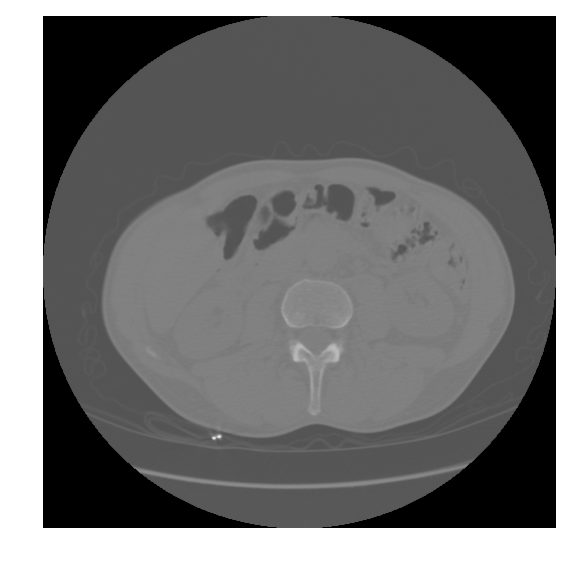

In [10]:
sitk_show(patient1[:,:,0], dpi=100)

We've just loaded and displayed one cross-sectional slice of the entire 3D lung scan for our first patient. Let's extend that and show the entire 3D stack:

/Users/chloe/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


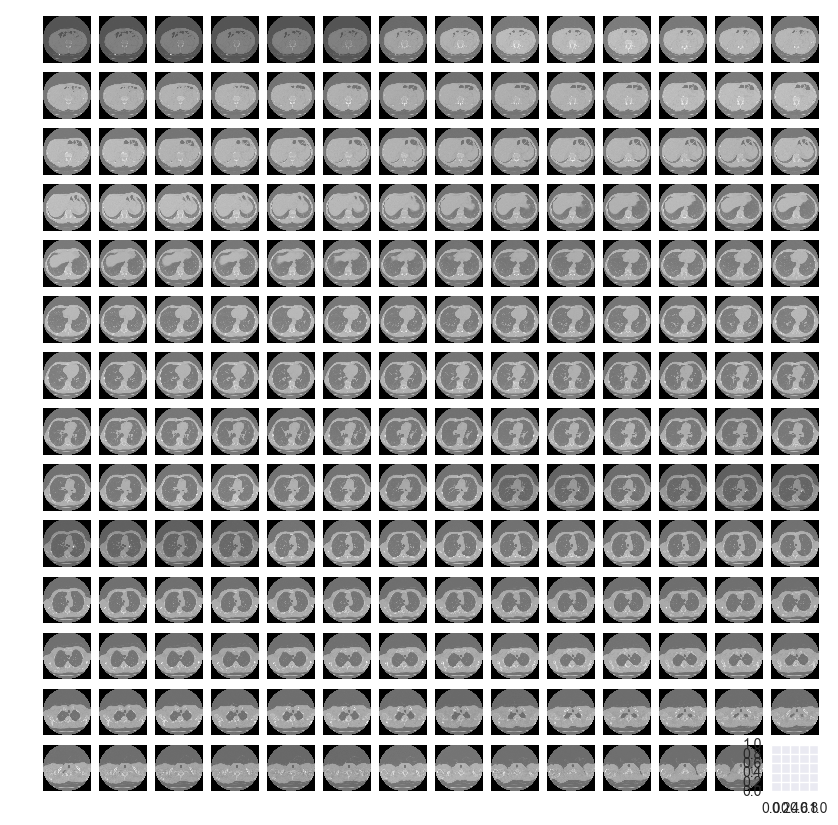

In [11]:
sitk_show_slices(patient1)

In [12]:
# Get image size
patient1.GetSize()

(512, 512, 195)

For this particular patient, we have 195 2D images stacked together to form our 3D picture. We can also directly examine the array values of our images like so:

In [13]:
# Get 3D array from patient image
SimpleITK.GetArrayFromImage(patient1)

array([[[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ..., 
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024]],

       [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ..., 
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024]],

       [[-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        ..., 
        [-3024, -3024, -3024, ..., -3024, -3024, -3024],
        [-3024, -3024, -3024, ..., -3024, 

#### Other patients

Now that we've confirmed the image loading process works, let's continue to load in the data from patients number 2, 3 and 4:

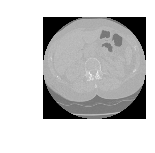

In [9]:
patient2 = load_images(train_labels.loc[1, 'id'])
sitk_show(patient2[:,:,0], dpi=500)

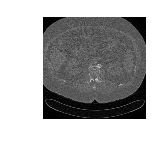

In [10]:
patient3 = load_images(train_labels.loc[2, 'id'])
sitk_show(patient3[:,:,0], dpi=500)

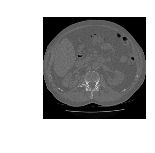

In [11]:
patient4 = load_images(train_labels.loc[3, 'id'])
sitk_show(patient4[:,:,0], dpi=500)

In [12]:
for patient in [patient1, patient2, patient3, patient4]:
    print patient.GetSize()

(512, 512, 195)
(512, 512, 265)
(512, 512, 233)
(512, 512, 173)


<a id='Part5'></a>

## 5. Define functions to pre-process images

Now for the meat of this part of the project: image processing. As mentioned in our problem statement, we have fairly hetergeneous images that require us to do some preprocessing and feature engineering before we can feed them into our Machine Learning models. 

Another significant point is that the large image sizes impose a significant memory requirement for training our Machine Learning models, especially for our Deep Neural Networks. We will follow this procedure:

a. Reshape image to 64x64x64

b. Remove noise

c. Segment the lungs

### a. Reshape image to 64x64x64

The `resample()` function here takes in individual patient images from our heterogeneously sized image dataset, then reshapes and outputs images with dimensions 64x64x64, which we have selected for now to ease the memory requirement on the neural networks that we will be using in the later parts of our project. As part of reshaping the z-dimension (i.e. direction along the stack of 2D images), we make use of `scipy` to interpolate between images. We also slice away the top and bottom regions of the images, as they were image regions that contained little relevant information for cancer diagnosis.

**Depending on the classification results and convergence time of our Machine Learning models in the later parts of this project, we may adjust the output dimensions of this image reshaping step as appropriate.**

In [15]:
import scipy.ndimage.interpolation

def resample(img, new_size=[84,64,64]):
    # Determine current pixel spacing
    size = np.array([img.GetSize()[2], img.GetSize()[1], img.GetSize()[0]])

    resize_factor = [float(x) for x in new_size] / size
    
    arr = SimpleITK.GetArrayFromImage(img)
    image = scipy.ndimage.interpolation.zoom(arr, resize_factor)
    
    # Slice away top and bottom useless parts
    image = image[10:-10]
    
    return image

This double checks that the reshaping has taken place successfully:

In [40]:
patient1_resampled = resample(patient1)
patient1_resampled.shape

(64, 64, 64)

/Users/chloe/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


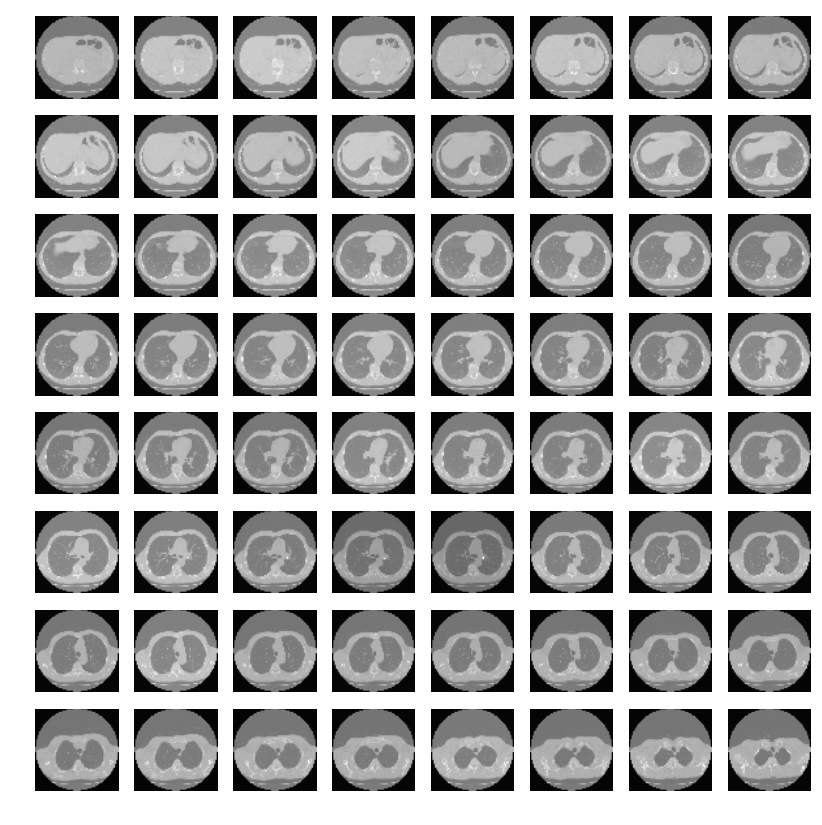

In [41]:
sitk_show_slices(SimpleITK.GetImageFromArray(patient1_resampled))

### b. Remove noise

With most image tasks, it is standard procedure to incorporate a noise removal step because real world data is usually noisy and would diminish the effectiveness of the Machine Learning models the data would be applied to. Thankfully, this dataset supplied by the US National Cancer Institute is of high quality and we're having acceptable results without including noise removal in our workflow.

Nevertheless, we've included below our helper function for reference:

### c. Segment the lungs 

Here we follow the Kaggle tutorial to perform this step of segmenting the lungs out from our resized images. It does several things to the images it is applied on:

- Separates regions in the lung scan images
- Eliminates the black halo found in some patients' scans
- Removes image regions that are not of interest, e.g. radio-opaque tissue in the lung area
- Masks the lung region and renormalises it
- Resets the background colour to enhance contrast

In [49]:
from sklearn.cluster import KMeans
from skimage import morphology, measure

# Segment the lungs
# Code from Kaggle tutorial

def segment_lungs(arr):
    # Produce a satisfactory separation of regions for both types of images 
    # and eliminate the black halo in some images
    middle = arr[5:60, 10:45,10:45] 
    mean = np.mean(middle)  
    max = np.max(arr)
    min = np.min(arr)
    #move the underflow bins
    arr[arr==max]=mean
    arr[arr==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_arr = np.where(arr<threshold,1.0,0.0)  # threshold the image

    # Use erosion and dilation to fill in the incursions into the lungs region by radio-opaque tissue 
    # and select the regions based on the bounding box sizes of each region
    eroded = morphology.erosion(thresh_arr)
    dilation = morphology.dilation(eroded)
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    
    # Cutting non-ROI regions
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[4]-B[1]<60 and B[5]-B[2]<60 and B[1]>5 and B[2]<60: # Check thresholds as the cuts applied to each region bounding box were determined empirically and seem to work well for the LUNA data, but may not be generally applicable
            good_labels.append(prop.label)
    mask = np.ndarray(thresh_arr.shape, dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask) # one last dilation
    
    # renormalizing the masked image (in the mask region)
    #
    new_mean = np.mean(arr[mask>0])  
    new_std = np.std(arr[mask>0])
    #
    #  Pushing the background color up to the lower end
    #  of the pixel range for the lungs
    #
    old_min = np.min(arr)       # background color
    arr[arr==old_min] = new_mean-1.2*new_std   # resetting backgound color
    arr = arr-new_mean
    arr = arr/new_std

    return arr*mask

In [50]:
patient1_segm = segment_lungs(patient1_resampled)

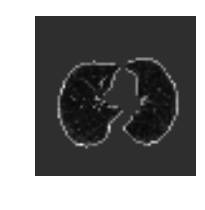

In [51]:
sitk_show(SimpleITK.GetImageFromArray(patient1_segm[40,:,:]))

-------------------

## Other preprocessing techniques to be explored for potential improvement  

During the course of our work preprocessing images, we explored other techniques that can potentially improve the quality of our images. They are documented here for reference, as well as possible incorporation into subsequent iterations of our project.

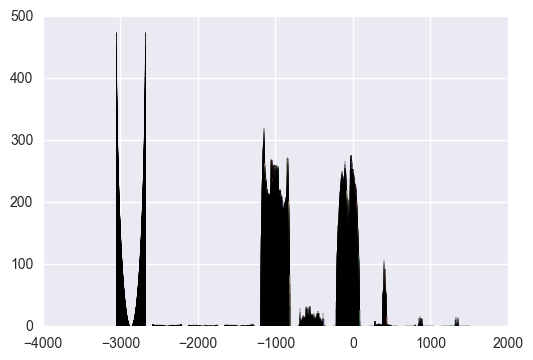

In [26]:
# Show histogram for patient 1
plt.hist(SimpleITK.GetArrayFromImage(patient1[:,:,0])) # Pixel values in HU
plt.show()

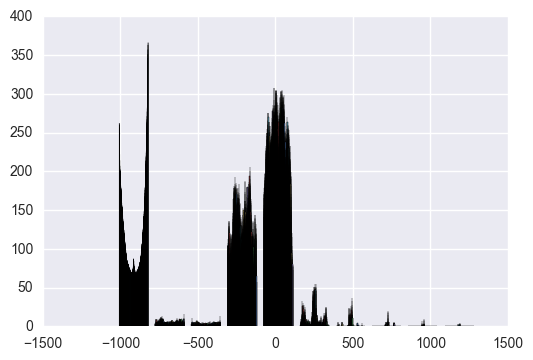

In [27]:
# Show histogram for patient 3 (no circle around the image)
plt.hist(SimpleITK.GetArrayFromImage(patient3[:,:,0]))
plt.show()

##### First method to remove black halos: change pixel values

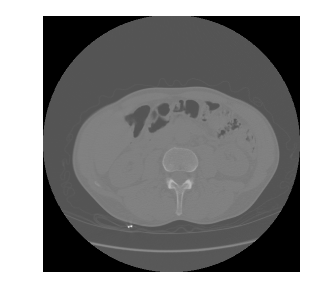

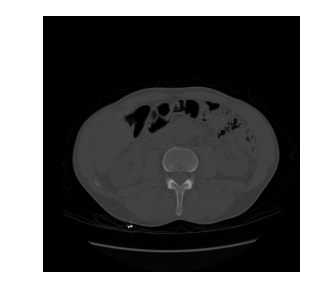

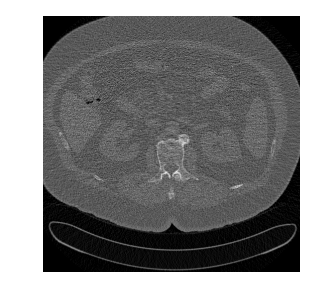

In [93]:
arr_patient1 = SimpleITK.GetArrayFromImage(patient1)
arr_patient3 = SimpleITK.GetArrayFromImage(patient3)

arr_patient1[arr_patient1 < -1000] = -1000

patient1_nohalo = SimpleITK.GetImageFromArray(arr_patient1)

sitk_show(patient1[:,:,0], dpi=200)
sitk_show(patient1_nohalo[:,:,0], dpi=200)
sitk_show(patient3[:,:,0], dpi=200)

##### Connected Filter segmentation based on seeds generated from thresholding segmentation

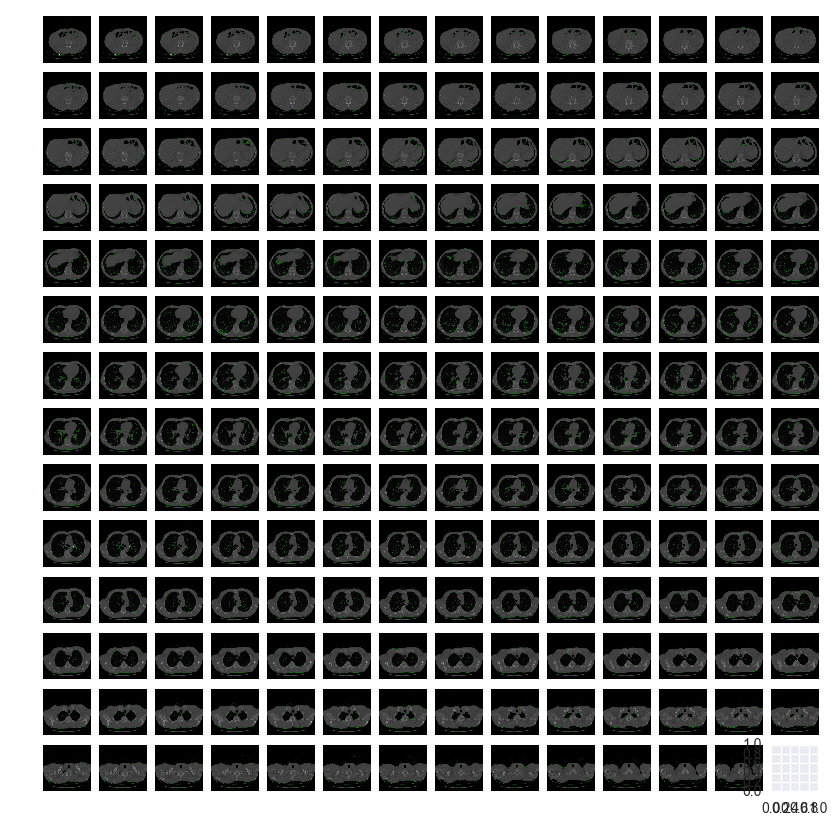

In [94]:
# Segment lungs based on intensity values - Lungs ~ -500HU

lung_thres = SimpleITK.BinaryThreshold(patient1_nohalo, lowerThreshold=-600, 
                                       upperThreshold=-400, insideValue=1, outsideValue=0)

# Rescale images intensity and change pixel type so they can be diplayed on the same image as lung_thres
patient1Int = SimpleITK.Cast(SimpleITK.RescaleIntensity(patient1_nohalo), lung_thres.GetPixelID())

    
sitk_show_slices(SimpleITK.LabelOverlay(patient1Int, lung_thres))

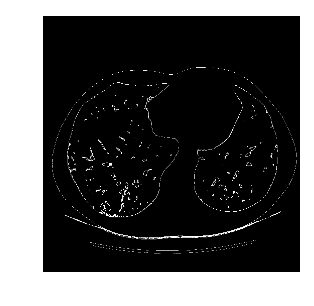

In [95]:
sitk_show(lung_thres[:,:,70], dpi=200)

In [96]:
# Find coordinates of points inside lungs - AUTOMATICALLY
# These will be used as seeds for the Confidence Connected filter that we will use to isolate the lungs

# In this case we will use all the point that were identified by the initial thresholding
seeds_auto = np.argwhere(SimpleITK.GetArrayFromImage(lung_thres)==1)

# Inverse dimensions as the function GetArryFromImage returns vertical image values in lines and horizontal image values in columns 
for seed in seeds_auto:
    seed[0], seed[1], seed[2] = seed[2], seed[1], seed[0]
    
# Only take points from the middle images
seeds_middle = []
for seed in seeds_auto:
    if seed[0]>250 and seed[0]<350 and seed[1]>250 and seed[1]<350 and seed[2]>40 and seed[2]<70:
            seeds_middle.append([seed[0], seed[1], seed[2]])

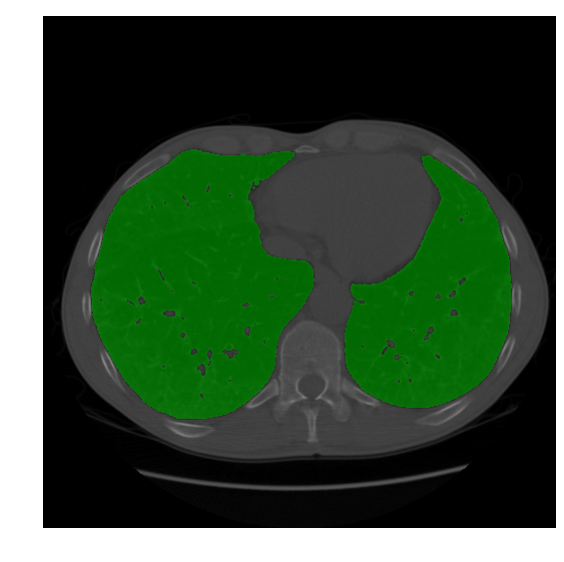

In [97]:
# Refine tumour segmentation based on list of seeds previously assigned with Confidence Connected filter
imgLungs = SimpleITK.ConfidenceConnected(image1=patient1_nohalo, 
                                               seedList=seeds_middle,
                                               numberOfIterations=3,
                                               multiplier=1.9,
                                               replaceValue=1)

# Display resulting segmentation on top of composed image
sitk_show(SimpleITK.LabelOverlay(patient1Int[:,:,70], imgLungs[:,:,70]), dpi=100)

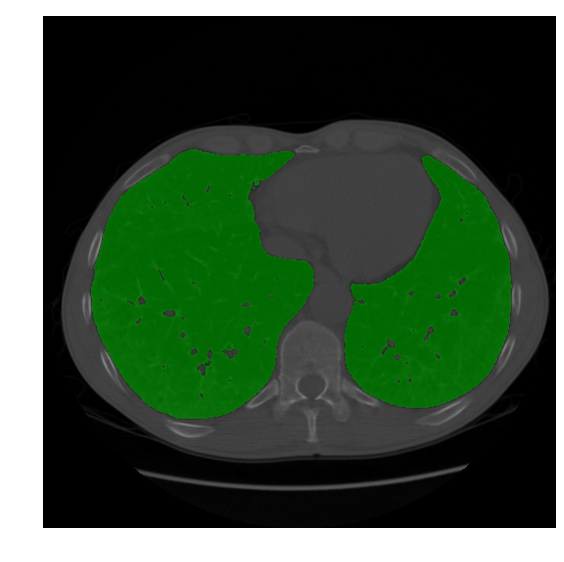

In [101]:
eroded = morphology.erosion(SimpleITK.GetArrayFromImage(imgLungs))
dilation = morphology.dilation(eroded)

sitk_show(SimpleITK.LabelOverlay(patient1Int[:,:,70], SimpleITK.GetImageFromArray(dilation[70,:,:])), dpi=100)

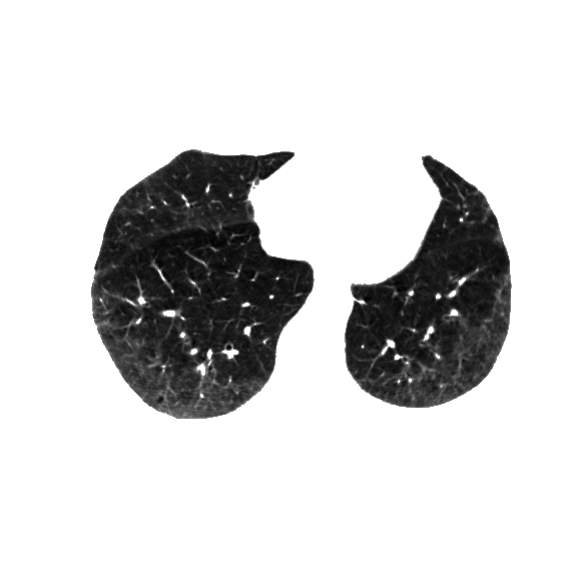

In [102]:
arr_patient1_nohalo = SimpleITK.GetArrayFromImage(patient1_nohalo)
arr_lungs = SimpleITK.GetArrayFromImage(imgLungs)

final_lungs_70 = arr_patient1_nohalo[70,:,:] * arr_lungs[70,:,:]

sitk_show(SimpleITK.GetImageFromArray(final_lungs_70), dpi = 100)

## Conclusion to Part 1 - Image Preprocessing

We've established a workflow that successfully preprocesses our image dataset to something that we can feed into our Machine Learning and Deep Learning models - check out out our Notebook for Part 2 of the project when it's available on our repo! This project has been brought to you by:

<p align="center">
<img src="" align="left" style="width: 85px;"/><img src="assets/chloe.jpeg" align="left" style="width: 85px;"/><img src="assets/ricky.jpeg" align="left" style="width: 85px;"/><img src="assets/martin.png" align="left" style="width: 85px;"/><img src="assets/matt.jpeg" align="left" style="width: 85px;"/>
</p>

[Chloe Pont](https://www.linkedin.com/in/chloepont/) | 
[Ricky Lui](https://www.linkedin.com/in/mingluiricky/) | 
[Martin Simanjuntak](https://www.linkedin.com/in/martinsimanjuntak/) | 
[Matthew Ho](https://www.linkedin.com/in/matthewwilfred/)